In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

import os
os.chdir("..")

import random
from tqdm import tqdm
from pathlib import Path
import numpy as np
import cv2
from joblib import Parallel, delayed, parallel_backend
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, cohen_kappa_score
from multiprocessing.dummy import Pool
import pandas as pd

from skin_lesion_cad.data.BOVW import DenseDescriptor, BagofWords, ColorDescriptor,LBPDescriptor
from skin_lesion_cad.features.colour import ColorFeaturesDescriptor
from skin_lesion_cad.features.colour import ColorFeaturesExtractor
from skin_lesion_cad.features.texture import glcm_features
from skin_lesion_cad.features.texture import get_glcm

import matplotlib.pyplot as plt
import seaborn as sns

from typing import Counter
from sklearn.base import TransformerMixin, BaseEstimator


import scipy

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
class ColorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
    def fit(self, X, y=None):
        X[np.isnan(X)] = 0
        X[np.isinf(X)] = 0
        return self.scaler.fit(X)
    def transform(self, X, y=None):
        X[np.isnan(X)] = 0
        X[np.isinf(X)] = 0
        return self.scaler.transform(X)
    
    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X)
        return self.transform(X, y)

In [4]:
SAMPLE_SIZE = 300
KP_SIZE = 25
color_spaces = {'bgr':cv2.COLOR_RGB2BGR, 'hsv':cv2.COLOR_RGB2HSV, 'YCrCb':cv2.COLOR_RGB2YCrCb}

root_path = Path().resolve()

chall1 = root_path/"data/processed/chall2/train"
mel_imgs = np.random.choice(list((chall1/'mel').glob("*inpaint_0_5.png")), SAMPLE_SIZE, replace=False)
bcc_imgs = np.random.choice(list((chall1/'bcc').glob("*inpaint_0_5.png")), SAMPLE_SIZE, replace=False)
scc_imgs = np.random.choice(list((chall1/'scc').glob("*inpaint_0_5.png")), SAMPLE_SIZE, replace=False)

test_imgs = np.concatenate([mel_imgs, bcc_imgs, scc_imgs])
brisk = cv2.BRISK_create(thresh=30, octaves=0)

# # use random sampling
# dense_desc = DenseDescriptor(descriptor=brisk, min_keypoints=100,
#                              max_keypoints=1000, kp_size=KP_SIZE,
#                              sample_method='random')


# dense_color = ColorDescriptor(dense_desc, color_spaces, meanshift=None,
#                               min_keypoints=100, max_keypoints=500,
#                               kp_size=25,
#                               sample_method='random')

# dense_texture = LBPDescriptor(descriptor=dense_desc,
#                                 min_keypoints=100, max_keypoints=500, 
#                                 kp_size=KP_SIZE,
#                                 sample_method='random')


# use gaussian sampling
dense_desc = DenseDescriptor(descriptor=None, min_keypoints=100,
                             max_keypoints=1000, kp_size=KP_SIZE,
                             sample_method='gaussian')


dense_color = ColorDescriptor(dense_desc, color_spaces, meanshift=None,
                              min_keypoints=100, max_keypoints=500,
                              kp_size=25,
                              sample_method='gaussian')

dense_texture = LBPDescriptor(descriptor=dense_desc,
                                min_keypoints=100, max_keypoints=500, 
                                kp_size=KP_SIZE,
                                sample_method='gaussian')


# 0. Baseline: separate BoW models for color and texture

In [3]:
def _load_and_extract_des_color_texture(x):
    image_path, descriptor = x
    im = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    # mask = cv2.imread(str(image_path).replace('inpaint', 'mask'))
    if 'bcc' in str(image_path):
        img_cls = 0
    elif 'mel' in str(image_path):
        img_cls = 1
    else:
        img_cls = 2

    kpts, des = descriptor.detectAndCompute(im, None)
    return (des, img_cls, image_path.name)


descriptors_texture = []
img_classes_texture = []
img_names_texture = []
# TEXTURE
with Pool(8) as pool:
    for (des, img_cls, img_name) in tqdm(pool.imap(_load_and_extract_des_color_texture,
                                       zip(test_imgs,
                                           [dense_texture]*len(test_imgs))), total=len(test_imgs)):
        descriptors_texture.append(des)
        img_classes_texture.append(img_cls)
        img_names_texture.append(img_name)

100%|██████████| 900/900 [01:27<00:00, 10.34it/s]


In [4]:
def _load_and_extract_des_color(x):
    image_path, descriptor = x
    im = cv2.imread(str(image_path))
    # mask = cv2.imread(str(image_path).replace('inpaint', 'mask'))
    if 'bcc' in str(image_path):
        img_cls = 0
    elif 'mel' in str(image_path):
        img_cls = 1
    else:
        img_cls = 2

    kpts, des = descriptor.detectAndCompute(im, None)
    return (des, img_cls, image_path.name)

descriptors_color = []
img_classes_color = []
img_names_color = []
# COLOR
with Pool(8) as pool:
    for (des, img_cls, img_name) in tqdm(pool.imap(_load_and_extract_des_color,
                                       zip(test_imgs,
                                           [dense_color]*len(test_imgs))), total=len(test_imgs)):
        descriptors_color.append(des)
        img_classes_color.append(img_cls)
        img_names_color.append(img_name)

  0%|          | 2/900 [00:06<39:31,  2.64s/it]  /home/vzalevskyi/anaconda3/envs/cad/lib/python3.10/site-packages/scipy/stats/_entropy.py:77: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/vzalevskyi/uni/MAIA_Semester_3/cad/skin-lesion-cad/skin_lesion_cad/features/colour.py:83: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew(pixels),
/home/vzalevskyi/uni/MAIA_Semester_3/cad/skin-lesion-cad/skin_lesion_cad/features/colour.py:84: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis(pixels),
100%|██████████| 900/900 [12:01<00:00,  1.25it/s]


In [13]:
bow_texture = BagofWords(n_words=100, n_jobs=-1, random_state=None)

kf = KFold(n_splits=5, shuffle=True)

scores = {'train_f1':[], 'test_f1':[], 'train_kappa':[], 'test_kappa':[]}
descriptors_texture = np.asarray(descriptors_texture)
img_classes_texture = np.asarray(img_classes_texture)
for train_index, test_index in tqdm(kf.split(descriptors_texture), total=kf.get_n_splits()):
    X_train, X_test = descriptors_texture[train_index], descriptors_texture[test_index]
    y_train, y_test = img_classes_texture[train_index], img_classes_texture[test_index]
    
    X_train_preprocessed = bow_texture.fit_transform(X_train,y_train) 
    X_test_preprocessed = bow_texture.transform(X_test)
    
    classifier = SVC(C=0.5, kernel='rbf', random_state=42, class_weight='balanced')
    classifier.fit(X_train_preprocessed,y_train)
    y_pred = classifier.predict(X_test_preprocessed)
    y_pred_train  = classifier.predict(X_train_preprocessed)
    
    scores['train_kappa'].append(cohen_kappa_score(y_pred_train, y_train))
    scores['train_f1'].append(f1_score(y_pred_train, y_train, average='macro'))
    scores['test_kappa'].append(cohen_kappa_score(y_pred, y_test))
    scores['test_f1'].append(f1_score(y_pred, y_test, average='macro'))

100%|██████████| 5/5 [00:47<00:00,  9.56s/it]


train_f1 0.7072011090161442  +- 0.013399015433620577
test_f1 0.4995806993596883  +- 0.017700726293324066
train_kappa 0.5659503845237771  +- 0.01772167419695396
test_kappa 0.2674572581824971  +- 0.03121573912601104


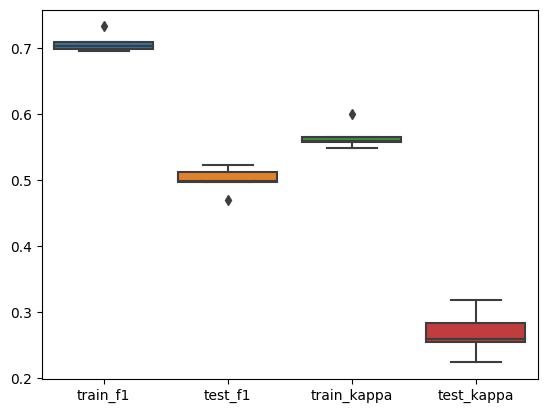

In [14]:
sns.boxplot(data=pd.DataFrame(scores))
for k, v in scores.items():
    print(k, np.mean(v), ' +-', np.std(v))

Random with brisk
```
train_f1 0.7799445657408125  +- 0.004393653741850997
test_f1 0.5073229550282539  +- 0.03189507346769425
train_kappa 0.6701373400986126  +- 0.006298608775474304
test_kappa 0.26761719945725104  +- 0.045155543376638595
```

In [28]:
bow_color = BagofWords(n_words=100, n_jobs=-1, random_state=None)

kf = KFold(n_splits=5, shuffle=True)

scores = {'train_f1':[], 'test_f1':[], 'train_kappa':[], 'test_kappa':[]}
descriptors_color = np.asarray(descriptors_color)
img_classes_color = np.asarray(img_classes_color)
for train_index, test_index in tqdm(kf.split(descriptors_color), total=kf.get_n_splits()):
    X_train, X_test = descriptors_color[train_index], descriptors_color[test_index]
    y_train, y_test = img_classes_color[train_index], img_classes_color[test_index]
    
    X_train_preprocessed = bow_color.fit_transform(X_train,y_train) 
    X_test_preprocessed = bow_color.transform(X_test)
    
    classifier = SVC(C=1., kernel='rbf', class_weight='balanced')
    classifier.fit(X_train_preprocessed,y_train)
    y_pred = classifier.predict(X_test_preprocessed)
    y_pred_train  = classifier.predict(X_train_preprocessed)
    
    scores['train_kappa'].append(cohen_kappa_score(y_pred_train, y_train))
    scores['train_f1'].append(f1_score(y_pred_train, y_train, average='macro'))
    scores['test_kappa'].append(cohen_kappa_score(y_pred, y_test))
    scores['test_f1'].append(f1_score(y_pred, y_test, average='macro'))

100%|██████████| 5/5 [00:42<00:00,  8.47s/it]


train_f1 0.7745518214274779  +- 0.010024826079446351
test_f1 0.6135931941434929  +- 0.027470629977677595
train_kappa 0.6615558750050717  +- 0.014591185739315568
test_kappa 0.42099020695883427  +- 0.04445127840262688


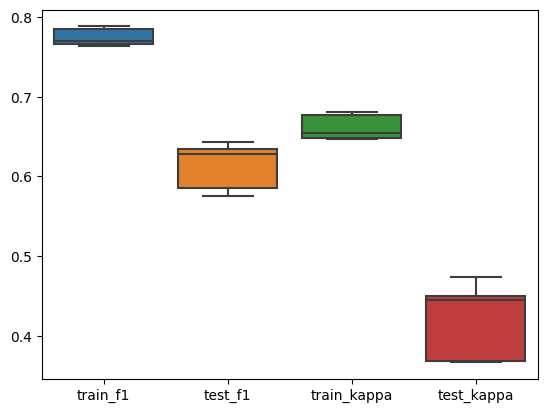

In [29]:
sns.boxplot(data=pd.DataFrame(scores))
for k, v in scores.items():
    print(k, np.mean(v), ' +-', np.std(v))

Random with color

```
train_f1 0.7666328568617333  +- 0.009875030921222225
test_f1 0.571777201448451  +- 0.023836374750108295
train_kappa 0.6499578398844867  +- 0.0156121466260396
test_kappa 0.3581376746541377  +- 0.03444177292288387
```

# 1. Fusing BoW vectors

In [26]:
color_df = pd.DataFrame({'img_name':img_names_color, 'img_class':img_classes_color}).reset_index().set_index('img_name')
texture_df = pd.DataFrame({'img_name':img_names_texture, 'img_class':img_classes_texture}).reset_index().set_index('img_name')
merged_df = color_df.join(texture_df, how='inner', lsuffix='_color', rsuffix='_texture')
merged_df

,index_color,img_class_color,index_texture,img_class_texture
img_name,,,,
mel00929_inpaint_0_5.png,0,1,0,1
mel01838_inpaint_0_5.png,1,1,1,1
mel02089_inpaint_0_5.png,2,1,2,1
mel01109_inpaint_0_5.png,3,1,3,1
mel01092_inpaint_0_5.png,4,1,4,1
...,...,...,...,...
scc00224_inpaint_0_5.png,895,2,895,2
scc00196_inpaint_0_5.png,896,2,896,2
scc00067_inpaint_0_5.png,897,2,897,2


With tf-idf as BoW vectors

In [56]:
kf = KFold(n_splits=5, shuffle=True)

scores = {'train_f1':[], 'test_f1':[], 'train_kappa':[], 'test_kappa':[]}
descriptors_color = np.asarray(descriptors_color)
img_classes_color = np.asarray(img_classes_color)

for train_index, test_index in tqdm(kf.split(merged_df), total=kf.get_n_splits()):
    
    # color bow
    bow_color = BagofWords(n_words=100, n_jobs=-1, random_state=None)
    train_index_color = merged_df.iloc[train_index].index_color
    test_index_color = merged_df.iloc[test_index].index_color
    X_train_color, X_test_color = descriptors_color[train_index_color], descriptors_color[test_index_color]
    y_train_color, y_test_color = img_classes_color[train_index_color], img_classes_color[test_index_color]
    
    X_train_preprocessed_color = bow_color.fit_transform(X_train_color,y_train_color) 
    X_test_preprocessed_color = bow_color.transform(X_test_color)
    
    # texture bow
    bow_texture = BagofWords(n_words=100, n_jobs=-1, random_state=None)
    train_index_texture = merged_df.iloc[train_index].index_texture
    test_index_texture = merged_df.iloc[test_index].index_texture
    X_train_texture, X_test_texture = descriptors_texture[train_index_texture], descriptors_texture[test_index_texture]
    y_train_texture, y_test_texture = img_classes_texture[train_index_texture], img_classes_texture[test_index_texture]
    
    X_train_preprocessed_texture = bow_texture.fit_transform(X_train_texture,y_train_texture) 
    X_test_preprocessed_texture = bow_texture.transform(X_test_texture)
    
    X_train_merged = scipy.sparse.hstack((X_train_preprocessed_color, X_train_preprocessed_texture))
    X_test_merged = scipy.sparse.hstack((X_test_preprocessed_color, X_test_preprocessed_texture))
    y_merged_train = y_train_color
    y_merged_test = y_test_color
    
    classifier = SVC(C=0.5, kernel='rbf', class_weight='balanced')
    classifier.fit(X_train_merged, y_merged_train)
    y_pred = classifier.predict(X_test_merged)
    y_pred_train  = classifier.predict(X_train_merged)
    
    scores['train_kappa'].append(cohen_kappa_score(y_pred_train, y_merged_train))
    scores['train_f1'].append(f1_score(y_pred_train, y_merged_train, average='macro'))
    scores['test_kappa'].append(cohen_kappa_score(y_pred, y_merged_test))
    scores['test_f1'].append(f1_score(y_pred, y_merged_test, average='macro'))

100%|██████████| 5/5 [01:20<00:00, 16.09s/it]


train_f1 0.7931442283423573  +- 0.015358488134882444
test_f1 0.6269851203441108  +- 0.03316029562365358
train_kappa 0.6901852708809846  +- 0.023422549925663644
test_kappa 0.4429449656313909  +- 0.051246811898764955


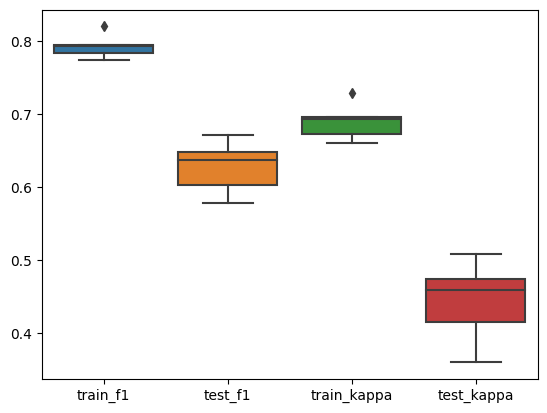

In [57]:
sns.boxplot(data=pd.DataFrame(scores))
for k, v in scores.items():
    print(k, np.mean(v), ' +-', np.std(v))

Without tf-idf and with simple term frequency
```

In [65]:
kf = KFold(n_splits=5, shuffle=True)

scores = {'train_f1':[], 'test_f1':[], 'train_kappa':[], 'test_kappa':[]}
descriptors_color = np.asarray(descriptors_color)
img_classes_color = np.asarray(img_classes_color)

for train_index, test_index in tqdm(kf.split(merged_df), total=kf.get_n_splits()):
    
    # color bow
    bow_color = BagofWords(n_words=100, n_jobs=-1, random_state=None)
    train_index_color = merged_df.iloc[train_index].index_color
    test_index_color = merged_df.iloc[test_index].index_color
    X_train_color, X_test_color = descriptors_color[train_index_color], descriptors_color[test_index_color]
    y_train_color, y_test_color = img_classes_color[train_index_color], img_classes_color[test_index_color]
    
    X_train_preprocessed_color = bow_color.fit_transform(X_train_color,y_train_color, get_tfidf=False) 
    X_test_preprocessed_color = bow_color.transform(X_test_color, get_tfidf=False)
    
    # texture bow
    bow_texture = BagofWords(n_words=100, n_jobs=-1, random_state=None)
    train_index_texture = merged_df.iloc[train_index].index_texture
    test_index_texture = merged_df.iloc[test_index].index_texture
    X_train_texture, X_test_texture = descriptors_texture[train_index_texture], descriptors_texture[test_index_texture]
    y_train_texture, y_test_texture = img_classes_texture[train_index_texture], img_classes_texture[test_index_texture]
    
    X_train_preprocessed_texture = bow_texture.fit_transform(X_train_texture,y_train_texture, get_tfidf=False) 
    X_test_preprocessed_texture = bow_texture.transform(X_test_texture, get_tfidf=False)
    
    X_train_merged = np.hstack((X_train_preprocessed_color, X_train_preprocessed_texture))
    X_test_merged = np.hstack((X_test_preprocessed_color, X_test_preprocessed_texture))
    y_merged_train = y_train_color
    y_merged_test = y_test_color
    
    classifier = SVC(C=0.5, kernel='rbf', class_weight='balanced')
    classifier.fit(X_train_merged, y_merged_train)
    y_pred = classifier.predict(X_test_merged)
    y_pred_train  = classifier.predict(X_train_merged)
    
    scores['train_kappa'].append(cohen_kappa_score(y_pred_train, y_merged_train))
    scores['train_f1'].append(f1_score(y_pred_train, y_merged_train, average='macro'))
    scores['test_kappa'].append(cohen_kappa_score(y_pred, y_merged_test))
    scores['test_f1'].append(f1_score(y_pred, y_merged_test, average='macro'))

100%|██████████| 5/5 [01:09<00:00, 13.92s/it]


train_f1 0.747840058239883  +- 0.008964767512710197
test_f1 0.6226512771543099  +- 0.01563449170545096
train_kappa 0.6215728351090825  +- 0.014641319443405925
test_kappa 0.4373163624173152  +- 0.019889656995561576


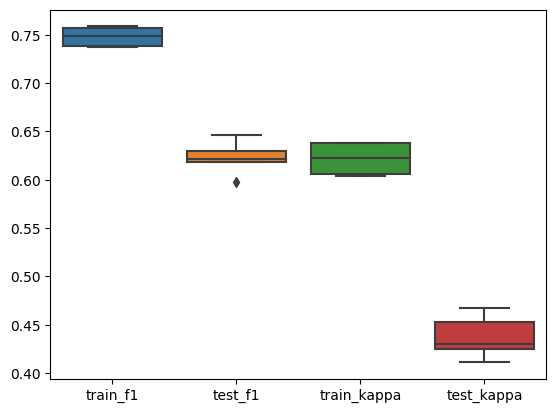

In [66]:
sns.boxplot(data=pd.DataFrame(scores))
for k, v in scores.items():
    print(k, np.mean(v), ' +-', np.std(v))

# 2. Global features: Color+Texture

#### Color

In [117]:
def extract_color(image_path):
    cfe = ColorFeaturesExtractor(color_spaces)
    im = cv2.imread(str(image_path))
    mask = np.ones_like(im[:,:,0]) #cv2.imread(str(image_path).replace('inpaint', 'mask'))
    if 'bcc' in str(image_path):
        img_cls = 0
    elif 'mel' in str(image_path):
        img_cls = 1
    else:
        img_cls = 2

    des = cfe.extract_masked(im, mask)

    return (des, img_cls, image_path.name)

colf = []
colcl = []
colnam = []
with Pool(8) as pool:
    for (des, img_cls, img_name) in tqdm(pool.imap(extract_color,
                                       test_imgs), total=len(test_imgs)):
        colf.append(des)
        colcl.append(img_cls)
        colnam.append(img_name)

100%|██████████| 900/900 [00:34<00:00, 25.89it/s]


In [118]:
glob_col = pd.DataFrame(colf)
glob_col['img_cls'] = colcl
glob_col['img_name'] = colnam
glob_col = glob_col.set_index('img_name')
glob_col

,bgr_b_mean,bgr_b_std,bgr_b_skew,bgr_b_kurt,bgr_b_max,bgr_b_min,bgr_b_entrp,bgr_b_unq,bgr_g_mean,bgr_g_std,...,YCrCb_C_unq,YCrCb_r_mean,YCrCb_r_std,YCrCb_r_skew,YCrCb_r_kurt,YCrCb_r_max,YCrCb_r_min,YCrCb_r_entrp,YCrCb_r_unq,img_cls
img_name,,,,,,,,,,,,,,,,,,,,,
mel00929_inpaint_0_5.png,161.524414,15.547001,-1.289008,1.752351,190.0,47.0,12.471781,141,168.211090,29.383680,...,4451,-4.082634,10.504489,0.296211,-0.955238,23.373585,-32.910797,-inf,4451,1
mel01838_inpaint_0_5.png,144.765869,25.101391,-0.766397,0.130455,190.0,32.0,11.103876,150,108.348862,41.180740,...,4403,17.306229,10.199120,-0.022993,-1.547046,38.290257,-3.372431,-inf,4087,1
mel02089_inpaint_0_5.png,90.086708,87.892921,0.366097,-1.381217,244.0,0.0,11.899383,245,77.698364,83.396515,...,10110,7.074957,10.630062,1.260800,0.211043,40.919060,-26.589487,-inf,10068,1
mel01109_inpaint_0_5.png,152.412659,82.475792,-0.960262,-0.792455,231.0,0.0,12.256440,232,148.362152,81.251221,...,6607,3.914836,6.443257,2.241042,4.667067,34.398090,-17.732426,-inf,6605,1
mel01092_inpaint_0_5.png,178.834885,19.845142,-1.070765,1.267778,214.0,15.0,11.113411,138,146.591995,31.738266,...,2253,17.457752,7.428773,1.451840,0.818860,43.367950,-9.037802,-inf,2146,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
scc00224_inpaint_0_5.png,187.428207,10.270455,-5.142198,41.281314,209.0,36.0,12.474957,168,171.390900,20.933035,...,4961,9.151346,8.973403,0.888384,-0.145515,39.133438,-7.513876,-inf,4961,2
scc00196_inpaint_0_5.png,170.398514,18.313015,-2.266938,8.345740,204.0,17.0,11.113438,175,112.070534,22.787506,...,5842,26.158911,5.369545,-0.056677,-0.221352,44.280502,-10.393096,-inf,5619,2
scc00067_inpaint_0_5.png,185.686783,13.441586,-2.507729,6.318456,201.0,100.0,12.473845,97,177.943527,21.460630,...,1893,6.283845,5.448598,1.909596,2.875876,35.522709,-0.336981,-inf,1893,2


100%|██████████| 5/5 [00:00<00:00, 73.77it/s]

train_f1 0.7182043899298545  +- 0.007322739807115989
test_f1 0.618939925297395  +- 0.024683339900304014
train_kappa 0.575  +- 0.011257713405088585
test_kappa 0.42666666666666664  +- 0.035512126254437525


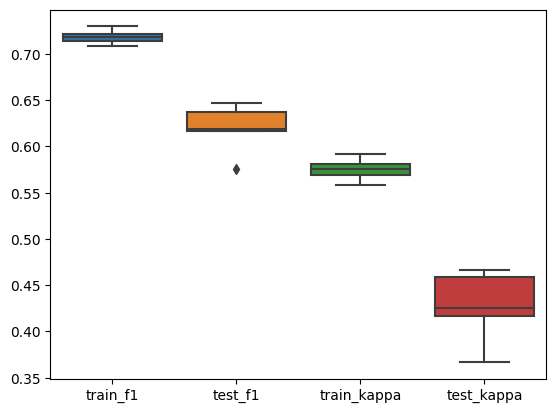

In [123]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

scores = {'train_f1':[], 'test_f1':[], 'train_kappa':[], 'test_kappa':[]}
for train_index, test_index in tqdm(kf.split(glob_col, glob_col.img_cls.values), total=kf.get_n_splits()):
    X_train = glob_col.drop(columns=['img_cls']).iloc[train_index].values
    X_test = glob_col.drop(columns=['img_cls']).iloc[test_index].values
    y_train = glob_col.iloc[train_index].img_cls.values
    y_test = glob_col.iloc[test_index].img_cls.values
    
    prep = ColorTransformer()
    X_train_preprocessed = prep.fit_transform(X_train,y_train) 
    X_test_preprocessed = prep.transform(X_test)
    
    classifier = SVC(C=0.5, kernel='rbf', random_state=42, class_weight='balanced')
    classifier.fit(X_train_preprocessed,y_train)
    y_pred = classifier.predict(X_test_preprocessed)
    y_pred_train  = classifier.predict(X_train_preprocessed)
    
    scores['train_kappa'].append(cohen_kappa_score(y_pred_train, y_train))
    scores['train_f1'].append(f1_score(y_pred_train, y_train, average='macro'))
    scores['test_kappa'].append(cohen_kappa_score(y_pred, y_test))
    scores['test_f1'].append(f1_score(y_pred, y_test, average='macro'))
    
sns.boxplot(data=pd.DataFrame(scores))
for k, v in scores.items():
    print(k, np.mean(v), ' +-', np.std(v))

#### Texture

In [77]:
def extract_text(image_path):
    im = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    if 'bcc' in str(image_path):
        img_cls = 0
    elif 'mel' in str(image_path):
        img_cls = 1
    else:
        img_cls = 2

    des = glcm_features(im)

    return (des, img_cls, image_path.name)

txtf = []
txtcl = []
txtnam = []
with Pool(8) as pool:
    for (des, img_cls, img_name) in tqdm(pool.imap(extract_text,
                                       test_imgs), total=len(test_imgs)):
        txtf.append(des)
        txtcl.append(img_cls)
        txtnam.append(img_name)

100%|██████████| 900/900 [00:14<00:00, 63.62it/s]


In [100]:
txtf_exp = []
for i in range(len(txtf)):
    res = dict()
    for feat in txtf[i].keys():
        for featvalidx, featval in enumerate(txtf[i][feat][0]):
            res[f'{feat}_{featvalidx}'] = featval
    txtf_exp.append(res)

glob_txt = pd.DataFrame(txtf_exp)
glob_txt['img_cls'] = txtcl
glob_txt['img_name'] = txtnam
glob_txt = glob_txt.set_index('img_name')
glob_txt

,contrast_0,contrast_1,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,contrast_7,dissimilarity_0,dissimilarity_1,...,correlation_7,ASM_0,ASM_1,ASM_2,ASM_3,ASM_4,ASM_5,ASM_6,ASM_7,img_cls
img_name,,,,,,,,,,,,,,,,,,,,,
mel00929_inpaint_0_5.png,8.109655,5.258217,8.432437,5.220273,26.250243,30.855567,26.623971,31.389779,2.076030,1.655497,...,0.977552,0.001568,0.001927,0.001534,0.001920,0.000889,0.000830,0.000876,0.000811,1
mel01838_inpaint_0_5.png,43.101208,30.352037,48.946487,31.734965,112.812324,147.427648,142.401167,149.191253,4.692737,3.909460,...,0.945362,0.000513,0.000607,0.000481,0.000587,0.000329,0.000299,0.000297,0.000285,1
mel02089_inpaint_0_5.png,39.457230,29.052780,47.870531,25.559319,145.862449,219.536762,191.341076,194.692650,3.153853,2.642296,...,0.986203,0.011210,0.011500,0.011278,0.011453,0.010260,0.009857,0.010283,0.009704,1
mel01109_inpaint_0_5.png,29.663017,17.757358,26.771523,18.805209,110.625512,132.780206,106.974760,136.779555,3.284295,2.501373,...,0.989316,0.002368,0.002699,0.002428,0.002633,0.001736,0.001721,0.001833,0.001688,1
mel01092_inpaint_0_5.png,21.242342,17.404175,26.213602,14.364623,49.746606,65.482023,64.704424,64.802831,2.778240,2.479276,...,0.960561,0.001504,0.001646,0.001333,0.001639,0.000962,0.000866,0.000868,0.000835,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
scc00224_inpaint_0_5.png,11.041150,9.216348,11.783226,5.925992,29.174310,36.740452,29.126333,26.449113,2.030863,1.803922,...,0.951594,0.002828,0.003108,0.002731,0.003291,0.001801,0.001601,0.001747,0.001755,2
scc00196_inpaint_0_5.png,38.102699,22.544508,38.370015,25.766379,108.975473,121.825180,105.412500,122.005259,4.350455,3.414970,...,0.864652,0.001097,0.001365,0.001085,0.001353,0.000661,0.000629,0.000664,0.000629,2
scc00067_inpaint_0_5.png,2.907701,1.802689,2.306292,1.750235,9.070020,9.466919,7.117885,9.979726,0.993892,0.783583,...,0.987351,0.012661,0.014680,0.014171,0.014858,0.007928,0.007948,0.010068,0.008342,2


100%|██████████| 5/5 [00:00<00:00, 88.96it/s]

train_f1 0.5064948901712685  +- 0.01026041975203413
test_f1 0.4810512080544579  +- 0.0572204930001122
train_kappa 0.26833333333333337  +- 0.01605113357021518
test_kappa 0.2333333333333333  +- 0.08449194570424383


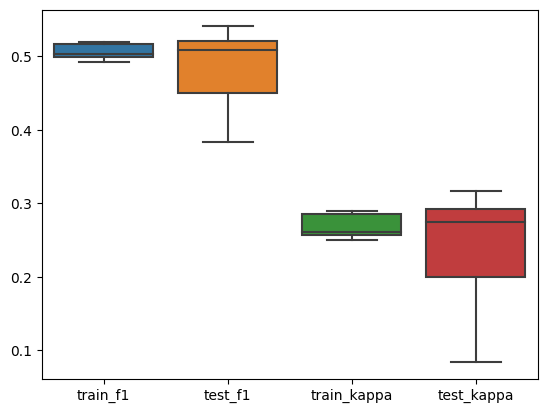

In [120]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

scores = {'train_f1':[], 'test_f1':[], 'train_kappa':[], 'test_kappa':[]}
for train_index, test_index in tqdm(kf.split(glob_txt, glob_txt.img_cls.values), total=kf.get_n_splits()):
    X_train = glob_txt.drop(columns=['img_cls']).iloc[train_index].values
    X_test = glob_txt.drop(columns=['img_cls']).iloc[test_index].values
    y_train = glob_txt.iloc[train_index].img_cls.values
    y_test = glob_txt.iloc[test_index].img_cls.values
    
    prep = ColorTransformer()
    X_train_preprocessed = prep.fit_transform(X_train,y_train) 
    X_test_preprocessed = prep.transform(X_test)
    
    classifier = SVC(C=0.5, kernel='rbf', random_state=42, class_weight='balanced')
    classifier.fit(X_train_preprocessed,y_train)
    y_pred = classifier.predict(X_test_preprocessed)
    y_pred_train  = classifier.predict(X_train_preprocessed)
    
    scores['train_kappa'].append(cohen_kappa_score(y_pred_train, y_train))
    scores['train_f1'].append(f1_score(y_pred_train, y_train, average='macro'))
    scores['test_kappa'].append(cohen_kappa_score(y_pred, y_test))
    scores['test_f1'].append(f1_score(y_pred, y_test, average='macro'))
    
sns.boxplot(data=pd.DataFrame(scores))
for k, v in scores.items():
    print(k, np.mean(v), ' +-', np.std(v))

#### Color+Texture

In [124]:
merged_global_df = glob_col.drop(columns=['img_cls']).join(glob_txt, how='inner')
merged_global_df

,bgr_b_mean,bgr_b_std,bgr_b_skew,bgr_b_kurt,bgr_b_max,bgr_b_min,bgr_b_entrp,bgr_b_unq,bgr_g_mean,bgr_g_std,...,correlation_7,ASM_0,ASM_1,ASM_2,ASM_3,ASM_4,ASM_5,ASM_6,ASM_7,img_cls
img_name,,,,,,,,,,,,,,,,,,,,,
mel00929_inpaint_0_5.png,161.524414,15.547001,-1.289008,1.752351,190.0,47.0,12.471781,141,168.211090,29.383680,...,0.977552,0.001568,0.001927,0.001534,0.001920,0.000889,0.000830,0.000876,0.000811,1
mel01838_inpaint_0_5.png,144.765869,25.101391,-0.766397,0.130455,190.0,32.0,11.103876,150,108.348862,41.180740,...,0.945362,0.000513,0.000607,0.000481,0.000587,0.000329,0.000299,0.000297,0.000285,1
mel02089_inpaint_0_5.png,90.086708,87.892921,0.366097,-1.381217,244.0,0.0,11.899383,245,77.698364,83.396515,...,0.986203,0.011210,0.011500,0.011278,0.011453,0.010260,0.009857,0.010283,0.009704,1
mel01109_inpaint_0_5.png,152.412659,82.475792,-0.960262,-0.792455,231.0,0.0,12.256440,232,148.362152,81.251221,...,0.989316,0.002368,0.002699,0.002428,0.002633,0.001736,0.001721,0.001833,0.001688,1
mel01092_inpaint_0_5.png,178.834885,19.845142,-1.070765,1.267778,214.0,15.0,11.113411,138,146.591995,31.738266,...,0.960561,0.001504,0.001646,0.001333,0.001639,0.000962,0.000866,0.000868,0.000835,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
scc00224_inpaint_0_5.png,187.428207,10.270455,-5.142198,41.281314,209.0,36.0,12.474957,168,171.390900,20.933035,...,0.951594,0.002828,0.003108,0.002731,0.003291,0.001801,0.001601,0.001747,0.001755,2
scc00196_inpaint_0_5.png,170.398514,18.313015,-2.266938,8.345740,204.0,17.0,11.113438,175,112.070534,22.787506,...,0.864652,0.001097,0.001365,0.001085,0.001353,0.000661,0.000629,0.000664,0.000629,2
scc00067_inpaint_0_5.png,185.686783,13.441586,-2.507729,6.318456,201.0,100.0,12.473845,97,177.943527,21.460630,...,0.987351,0.012661,0.014680,0.014171,0.014858,0.007928,0.007948,0.010068,0.008342,2


100%|██████████| 5/5 [00:00<00:00, 65.51it/s]

train_f1 0.7046368028100807  +- 0.013417755687054026
test_f1 0.6029881160472293  +- 0.030055961425454976
train_kappa 0.55625  +- 0.020284435741063478
test_kappa 0.40499999999999997  +- 0.043011626335213125


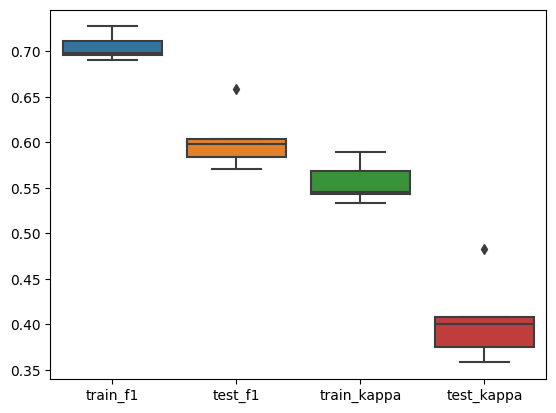

In [129]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

scores = {'train_f1':[], 'test_f1':[], 'train_kappa':[], 'test_kappa':[]}
for train_index, test_index in tqdm(kf.split(merged_global_df, merged_global_df.img_cls.values), total=kf.get_n_splits()):
    X_train = merged_global_df.drop(columns=['img_cls']).iloc[train_index].values
    X_test = merged_global_df.drop(columns=['img_cls']).iloc[test_index].values
    y_train = merged_global_df.iloc[train_index].img_cls.values
    y_test = merged_global_df.iloc[test_index].img_cls.values
    
    prep = ColorTransformer()
    X_train_preprocessed = prep.fit_transform(X_train,y_train) 
    X_test_preprocessed = prep.transform(X_test)
    
    classifier = SVC(C=0.5, kernel='rbf', random_state=42, class_weight='balanced')
    classifier.fit(X_train_preprocessed,y_train)
    y_pred = classifier.predict(X_test_preprocessed)
    y_pred_train  = classifier.predict(X_train_preprocessed)
    
    scores['train_kappa'].append(cohen_kappa_score(y_pred_train, y_train))
    scores['train_f1'].append(f1_score(y_pred_train, y_train, average='macro'))
    scores['test_kappa'].append(cohen_kappa_score(y_pred, y_test))
    scores['test_f1'].append(f1_score(y_pred, y_test, average='macro'))
    
sns.boxplot(data=pd.DataFrame(scores))
for k, v in scores.items():
    print(k, np.mean(v), ' +-', np.std(v))

# 3. Combine BoW with global color + texture

In [132]:
merged_df

,index_color,img_class_color,index_texture,img_class_texture
img_name,,,,
mel00929_inpaint_0_5.png,0,1,0,1
mel01838_inpaint_0_5.png,1,1,1,1
mel02089_inpaint_0_5.png,2,1,2,1
mel01109_inpaint_0_5.png,3,1,3,1
mel01092_inpaint_0_5.png,4,1,4,1
...,...,...,...,...
scc00224_inpaint_0_5.png,895,2,895,2
scc00196_inpaint_0_5.png,896,2,896,2
scc00067_inpaint_0_5.png,897,2,897,2


In [131]:
merged_global_df

,bgr_b_mean,bgr_b_std,bgr_b_skew,bgr_b_kurt,bgr_b_max,bgr_b_min,bgr_b_entrp,bgr_b_unq,bgr_g_mean,bgr_g_std,...,correlation_7,ASM_0,ASM_1,ASM_2,ASM_3,ASM_4,ASM_5,ASM_6,ASM_7,img_cls
img_name,,,,,,,,,,,,,,,,,,,,,
mel00929_inpaint_0_5.png,161.524414,15.547001,-1.289008,1.752351,190.0,47.0,12.471781,141,168.211090,29.383680,...,0.977552,0.001568,0.001927,0.001534,0.001920,0.000889,0.000830,0.000876,0.000811,1
mel01838_inpaint_0_5.png,144.765869,25.101391,-0.766397,0.130455,190.0,32.0,11.103876,150,108.348862,41.180740,...,0.945362,0.000513,0.000607,0.000481,0.000587,0.000329,0.000299,0.000297,0.000285,1
mel02089_inpaint_0_5.png,90.086708,87.892921,0.366097,-1.381217,244.0,0.0,11.899383,245,77.698364,83.396515,...,0.986203,0.011210,0.011500,0.011278,0.011453,0.010260,0.009857,0.010283,0.009704,1
mel01109_inpaint_0_5.png,152.412659,82.475792,-0.960262,-0.792455,231.0,0.0,12.256440,232,148.362152,81.251221,...,0.989316,0.002368,0.002699,0.002428,0.002633,0.001736,0.001721,0.001833,0.001688,1
mel01092_inpaint_0_5.png,178.834885,19.845142,-1.070765,1.267778,214.0,15.0,11.113411,138,146.591995,31.738266,...,0.960561,0.001504,0.001646,0.001333,0.001639,0.000962,0.000866,0.000868,0.000835,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
scc00224_inpaint_0_5.png,187.428207,10.270455,-5.142198,41.281314,209.0,36.0,12.474957,168,171.390900,20.933035,...,0.951594,0.002828,0.003108,0.002731,0.003291,0.001801,0.001601,0.001747,0.001755,2
scc00196_inpaint_0_5.png,170.398514,18.313015,-2.266938,8.345740,204.0,17.0,11.113438,175,112.070534,22.787506,...,0.864652,0.001097,0.001365,0.001085,0.001353,0.000661,0.000629,0.000664,0.000629,2
scc00067_inpaint_0_5.png,185.686783,13.441586,-2.507729,6.318456,201.0,100.0,12.473845,97,177.943527,21.460630,...,0.987351,0.012661,0.014680,0.014171,0.014858,0.007928,0.007948,0.010068,0.008342,2


In [134]:
merged_df_global_bow = merged_global_df.drop(columns=['img_cls']).join(merged_df, how='inner')
merged_df_global_bow



,bgr_b_mean,bgr_b_std,bgr_b_skew,bgr_b_kurt,bgr_b_max,bgr_b_min,bgr_b_entrp,bgr_b_unq,bgr_g_mean,bgr_g_std,...,ASM_2,ASM_3,ASM_4,ASM_5,ASM_6,ASM_7,index_color,img_class_color,index_texture,img_class_texture
img_name,,,,,,,,,,,,,,,,,,,,,
mel00929_inpaint_0_5.png,161.524414,15.547001,-1.289008,1.752351,190.0,47.0,12.471781,141,168.211090,29.383680,...,0.001534,0.001920,0.000889,0.000830,0.000876,0.000811,0,1,0,1
mel01838_inpaint_0_5.png,144.765869,25.101391,-0.766397,0.130455,190.0,32.0,11.103876,150,108.348862,41.180740,...,0.000481,0.000587,0.000329,0.000299,0.000297,0.000285,1,1,1,1
mel02089_inpaint_0_5.png,90.086708,87.892921,0.366097,-1.381217,244.0,0.0,11.899383,245,77.698364,83.396515,...,0.011278,0.011453,0.010260,0.009857,0.010283,0.009704,2,1,2,1
mel01109_inpaint_0_5.png,152.412659,82.475792,-0.960262,-0.792455,231.0,0.0,12.256440,232,148.362152,81.251221,...,0.002428,0.002633,0.001736,0.001721,0.001833,0.001688,3,1,3,1
mel01092_inpaint_0_5.png,178.834885,19.845142,-1.070765,1.267778,214.0,15.0,11.113411,138,146.591995,31.738266,...,0.001333,0.001639,0.000962,0.000866,0.000868,0.000835,4,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
scc00224_inpaint_0_5.png,187.428207,10.270455,-5.142198,41.281314,209.0,36.0,12.474957,168,171.390900,20.933035,...,0.002731,0.003291,0.001801,0.001601,0.001747,0.001755,895,2,895,2
scc00196_inpaint_0_5.png,170.398514,18.313015,-2.266938,8.345740,204.0,17.0,11.113438,175,112.070534,22.787506,...,0.001085,0.001353,0.000661,0.000629,0.000664,0.000629,896,2,896,2
scc00067_inpaint_0_5.png,185.686783,13.441586,-2.507729,6.318456,201.0,100.0,12.473845,97,177.943527,21.460630,...,0.014171,0.014858,0.007928,0.007948,0.010068,0.008342,897,2,897,2


In [155]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

scores = {'train_f1':[], 'test_f1':[], 'train_kappa':[], 'test_kappa':[]}


for train_index, test_index in tqdm(kf.split(merged_df_global_bow.drop(columns=['img_class_color',
                                                                                'img_class_texture']),
                                             merged_df_global_bow.img_class_texture.values),
                                    total=kf.get_n_splits()):
    
    # color bow
    bow_color = BagofWords(n_words=100, n_jobs=-1, random_state=None)
    train_index_color = merged_df_global_bow.iloc[train_index].index_color
    test_index_color = merged_df_global_bow.iloc[test_index].index_color
    X_train_color, X_test_color = descriptors_color[train_index_color], descriptors_color[test_index_color]
    y_train_color, y_test_color = img_classes_color[train_index_color], img_classes_color[test_index_color]
    
    X_train_preprocessed_color = bow_color.fit_transform(X_train_color,y_train_color) 
    X_test_preprocessed_color = bow_color.transform(X_test_color)
    
    # texture bow
    bow_texture = BagofWords(n_words=100, n_jobs=-1, random_state=None)
    train_index_texture = merged_df_global_bow.iloc[train_index].index_texture
    test_index_texture = merged_df_global_bow.iloc[test_index].index_texture
    X_train_texture, X_test_texture = descriptors_texture[train_index_texture], descriptors_texture[test_index_texture]
    y_train_texture, y_test_texture = img_classes_texture[train_index_texture], img_classes_texture[test_index_texture]
    
    X_train_preprocessed_texture = bow_texture.fit_transform(X_train_texture,y_train_texture) 
    X_test_preprocessed_texture = bow_texture.transform(X_test_texture)
    
    train_global = merged_df_global_bow.iloc[train_index].drop(columns=['index_color',
                                                                        'img_class_color',
                                                                        'index_texture',
                                                                        'img_class_texture']).values
    test_global = merged_df_global_bow.iloc[test_index].drop(columns=['index_color',
                                                                        'img_class_color',
                                                                        'index_texture',
                                                                        'img_class_texture']).values
    scl = ColorTransformer()
    train_global = scl.fit_transform(train_global)
    test_global = scl.transform(test_global)
    
    X_train_merged = scipy.sparse.hstack((X_train_preprocessed_color, X_train_preprocessed_texture))
    X_train_merged = np.hstack([X_train_merged.toarray(), train_global])

    X_test_merged = scipy.sparse.hstack((X_test_preprocessed_color, X_test_preprocessed_texture))
    X_test_merged = np.hstack([X_test_merged.toarray(), test_global])

    
    y_merged_train = y_train_color
    y_merged_test = y_test_color
    
    classifier = SVC(C=0.5, kernel='rbf', class_weight='balanced')
    classifier.fit(X_train_merged, y_merged_train)
    y_pred = classifier.predict(X_test_merged)
    y_pred_train  = classifier.predict(X_train_merged)
    
    scores['train_kappa'].append(cohen_kappa_score(y_pred_train, y_merged_train))
    scores['train_f1'].append(f1_score(y_pred_train, y_merged_train, average='macro'))
    scores['test_kappa'].append(cohen_kappa_score(y_pred, y_merged_test))
    scores['test_f1'].append(f1_score(y_pred, y_merged_test, average='macro'))

100%|██████████| 5/5 [01:39<00:00, 19.87s/it]


train_f1 0.7895763305569337  +- 0.01602515817080367
test_f1 0.6244769241535731  +- 0.02355292388667912
train_kappa 0.6845833333333333  +- 0.023071446999845216
test_kappa 0.44000000000000006  +- 0.04027681991198192


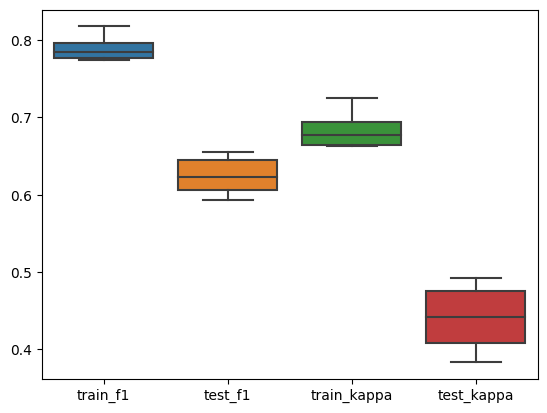

In [143]:
sns.boxplot(data=pd.DataFrame(scores))
for k, v in scores.items():
    print(k, np.mean(v), ' +-', np.std(v))

# 4. Check how many words preferably 10, 20, 50, 100, 200, 500, 1000

# 5. Check if KNN Imputer better then replacing NaN and infinities with 0

In [5]:
root_path = Path().resolve()


chall1 = root_path/"data/processed/chall2/val"

mel_imgs_all = np.array(list((chall1/'mel').glob("*inpaint_0_5.png")))
bcc_imgs_all = np.array(list((chall1/'bcc').glob("*inpaint_0_5.png")))
scc_imgs_all = np.array(list((chall1/'scc').glob("*inpaint_0_5.png")))



test_imgs = np.concatenate([mel_imgs_all, bcc_imgs_all, scc_imgs_all])

In [6]:
def _load_and_extract_des_color(x):
    image_path, descriptor = x
    im = cv2.imread(str(image_path))
    # mask = cv2.imread(str(image_path).replace('inpaint', 'mask'))
    if 'bcc' in str(image_path):
        img_cls = 0
    elif 'mel' in str(image_path):
        img_cls = 1
    else:
        img_cls = 2

    kpts, des = descriptor.detectAndCompute(im, None)
    return (des, img_cls, image_path.name)

descriptors_color = []
img_classes_color = []
img_names_color = []
# COLOR
with Pool(8) as pool:
    for (des, img_cls, img_name) in tqdm(pool.imap(_load_and_extract_des_color,
                                       zip(test_imgs,
                                           [dense_color]*len(test_imgs))), total=len(test_imgs)):
        descriptors_color.append(des)
        img_classes_color.append(img_cls)
        img_names_color.append(img_name)

  0%|          | 2/1270 [00:17<2:33:42,  7.27s/it]/home/vzalevskyi/anaconda3/envs/cad/lib/python3.10/site-packages/scipy/stats/_entropy.py:77: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/vzalevskyi/uni/MAIA_Semester_3/cad/skin-lesion-cad/skin_lesion_cad/features/colour.py:83: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew(pixels),
/home/vzalevskyi/uni/MAIA_Semester_3/cad/skin-lesion-cad/skin_lesion_cad/features/colour.py:84: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis(pixels),
100%|██████████| 1270/1270 [41:34<00:00,  1.96s/it] 


In [7]:
pd.to_pickle((descriptors_color, img_classes_color, img_names_color), 'descriptors_color_all_val_gauss.pkl')

In [8]:
def _load_and_extract_des_color_texture(x):
    image_path, descriptor = x
    im = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    # mask = cv2.imread(str(image_path).replace('inpaint', 'mask'))
    if 'bcc' in str(image_path):
        img_cls = 0
    elif 'mel' in str(image_path):
        img_cls = 1
    else:
        img_cls = 2

    kpts, des = descriptor.detectAndCompute(im, None)
    return (des, img_cls, image_path.name)


descriptors_texture = []
img_classes_texture = []
img_names_texture = []
# TEXTURE
with Pool(8) as pool:
    for (des, img_cls, img_name) in tqdm(pool.imap(_load_and_extract_des_color_texture,
                                       zip(test_imgs,
                                           [dense_texture]*len(test_imgs))), total=len(test_imgs)):
        descriptors_texture.append(des)
        img_classes_texture.append(img_cls)
        img_names_texture.append(img_name)

100%|██████████| 1270/1270 [03:02<00:00,  6.95it/s]


In [9]:
pd.to_pickle((descriptors_texture, img_classes_texture, img_names_texture), 'descriptors_texture_all_val_gauss.pkl')

# TODO
1. Replace KFold with Stratified K-Fold
    * ```TypeError: StratifiedKFold.split() missing 1 required positional argument: 'y'```
2. Check that SVM balaned weights are working
3